<a href="https://colab.research.google.com/github/tiara070403/skripsi/blob/main/skripsilagii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Sastrawi
!pip install tweet-preprocessor
!pip install textblob
!pip install wordcloud
!pip install nltk

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import pipeline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
df = pd.read_csv('/content/crawling.csv', index_col=0)

In [4]:
df_copy = df.copy()

In [5]:
df = df[['created_at', 'full_text']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5349 entries, 1858070162362204643 to 1230765438897815552
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5349 non-null   object
 1   full_text   5349 non-null   object
dtypes: object(2)
memory usage: 125.4+ KB


In [8]:
df['full_text'] = df['full_text'].astype(str).str.lower()  # Mengubah teks menjadi lowercase
df['full_text'] = df['full_text'].replace('false', pd.NA)
df = df.dropna(subset=['full_text'])

In [9]:
df = df.drop_duplicates(subset=['full_text'])

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
print(f"\nJumlah duplikat setelah drop: {df.duplicated().sum()}")


Jumlah duplikat setelah drop: 0


In [12]:
df = df.dropna()

In [13]:
print(f"\nJumlah nilai null setelah dropna: \n{df.isnull().sum()}")


Jumlah nilai null setelah dropna: 
created_at    0
full_text     0
dtype: int64


In [14]:
df.isnull().sum()

,0
created_at,0
full_text,0


In [15]:
# Case Folding
df['full_text'] = df['full_text'].str.lower()
print("\nDataFrame setelah Case Folding:")
print(df.head())


DataFrame setelah Case Folding:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi 'genjot...  
1467691301155979267  @leonita_lestari ada perkoempoelan pentjinta a...  
1836014724523458593  [press release sowan ukm ke ukm unit pandu lin...  
1835164951125917967  [press release sowan ukm ke ukm unit pandu lin...  


In [16]:
# Cleaning
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?://\S+', '', text)
  text = re.sub(r'[^A-Za-z0-9 ]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text
df['full_text'] = df['full_text'].apply(clean_twitter_text)
print(f"\nShape setelah Cleaning: {df.shape}")
print("DataFrame setelah Cleaning:")
print(df.head())


Shape setelah Cleaning: (5246, 2)
DataFrame setelah Cleaning:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi genjot ...  
1467691301155979267  ada perkoempoelan pentjinta alam yang lahir th...  
1836014724523458593  press release sowan ukm ke ukm unit pandu ling...  
1835164951125917967  press release sowan ukm ke ukm unit pandu ling...  


In [17]:
def filter_tokens_by_length(df, column, min_words, max_words):
    words_count = df[column].astype(str).apply(lambda x: len(x.split()))
    mask = (words_count >= min_words) & (words_count <= max_words)
    filtered_df = df[mask]
    return filtered_df
min_words = 3
max_words = 4000
df = filter_tokens_by_length(df, 'full_text', min_words, max_words)
print(f"\nShape setelah Filter Token Length: {df.shape}")
print("DataFrame setelah Filter Token Length:")
print(df.head())


Shape setelah Filter Token Length: (5170, 2)
DataFrame setelah Filter Token Length:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643            lucu banget mahasiswa pencinta alam ini  
1846529554657239219  bejat mahasiswa pencinta alam di jambi genjot ...  
1467691301155979267  ada perkoempoelan pentjinta alam yang lahir th...  
1836014724523458593  press release sowan ukm ke ukm unit pandu ling...  
1835164951125917967  press release sowan ukm ke ukm unit pandu ling...  


In [24]:
# Normalisasi Data
norm = {'kekekekegiatanananan':'kegiatan', 'press release': 'siaran pers', 'ukamu': 'ukm', 'giat': 'kegiatan', 'luring': 'luring', 'sekre': 'sekretariat', 'mapala': 'mahasiswa pencinta alam', 'kocak': 'lucu', 'enak': 'enak', 'bilang': 'bilang', 'sowan': 'mengunjungi', 'buka': 'membuka', 'sampai': 'hingga', 'pukul': 'jam', 'sd': 'sampai', 'kapan': 'kapan', 'mau': 'ingin', 'join': 'bergabung', 'sama': 'bersama', 'bisa': 'dapat', 'bantu': 'membantu', 'kamu': 'kamu', 'sama': 'bersama', 'bisa': 'dapat', 'sama': 'bersama', ' mikir2 ':' mikir ', 'perkoempoelan':'perkumpulan', 'sowan':'menghadap', 'genjot':'menyerang', 'wkwkw':'hahaha', 'gtgtgt':'.', 'th':'tahun', 'ukamu':'ukm', 'bejat':'rusak', 'pentjinta':'pencinta', 'pecinta':'pencinta', ' siaaapp ':' siap ', 'okaaay ':'oke ', 'udh ':'sudah ','ga ':'tidak ',' gaskeun':' ayo ', 'wowww ':'wow ', ' haaayyuukkk ':' ayo ', ' yg ':' yang ', ' udh ':' udah ', 'wkwk ':' ', ' min ':' kak ', ' malem ':' malam', ' malem2 ':' malam ', ' sm ':' sama ', ' dy ':' dia ', ' lg ':' lagi ', ' skrg ':' sekarang ', ' ddpn ':' didepan ', ' makasi ':' makasih ', ' pertamaz ':' pertamax ', ' jg ':' juga ', ' donk ':' dong ', ' ikutann ':' ikutan ', ' banyakk ':' banyak ', ' twt ':' tweet', 'mantaap ':'mantap ', ' juarak':' juara ', 'daridulu ':'dari dulu ', 'siapp ':'siap ', ' gamau ':' tidak mau ', ' sll ':' selalu ', ' qu ':' aku ', ' krn ':' karena ', ' irii':' iri', ' muluu ':' terus ', 'mada ':'masa ', 'jgn ':'jangan ', ' jgn ':' jangan ', ' muluuu ':' terus ', 'ntar ':'nanti ', ' awtnya':' awetnya', 'gg ':'keren ', ' kerennn':' keren ', ' bisaa ':' bisa ', 'gaaa':'tidak ', " yg ": " yang ", ' nyampe':' sampai', ' nyampe ':' sampai ', ' lu ':' kamu ', ' ikhlaaasss ':' ikhlas ', ' gak ':' tidak ', ' klo ':' kalo ', ' amp ': ' sampai ', ' ga ':' tidak ', ' yaaaa':' ya ', 'betolll ':'betul ', ' kaga ':' tidak ', ' idk ':' tidak tahu ', ' jkt ':' jakarta ', ' lo ':' kamu ', ' bjir ':' ', ' kek ':' seperti ', ' yg ':' yang ', ' utk ':' untuk ', 'kismin ':'miskin ', ' kismin ':' miskin ', ' pd ':' pada ', ' dgn ':' dengan ', ' ituu ':' itu ', ' jg ':' juga ', 'yoi':'iya ', ' yoi ':' iya ', 'org2 ':'orang ', ' tak ':' tidak ', ' kyk ':' seperti ', ' sbg ':' sebagai ', ' anjjjj ':' ', ' bgt ':' banget ', 'km ':'kamu ', ' km ':' kamu', ' byk ':' banyak ', ' lg ':' lagi ', ' mrk ':' mereka ', ' blm ':' belum '}
def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text
df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))
print("\nDataFrame setelah Normalisasi:")
print(df.head())


DataFrame setelah Normalisasi:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643                lucu banget mahasiswa pencinta alam  
1846529554657239219  rusak mahasiswa pencinta alam jambi menyerang ...  
1467691301155979267  perkumpulan pencinta alam lahir tahun 1953 did...  
1836014724523458593  siaran pers menghadap ukamu unit pandu lingkun...  
1835164951125917967  siaran pers menghadap ukamu unit pandu lingkun...  


In [25]:
# Stopwords Removal
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = ['anjayyy']
stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)
def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text
df['full_text'] = df['full_text'].apply(lambda x: stopword(x))
print("\nDataFrame setelah Stopwords Removal:")
print(df.head())


DataFrame setelah Stopwords Removal:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643                lucu banget mahasiswa pencinta alam  
1846529554657239219  rusak mahasiswa pencinta alam jambi menyerang ...  
1467691301155979267  perkumpulan pencinta alam lahir tahun 1953 did...  
1836014724523458593  siaran pers menghadap ukamu unit pandu lingkun...  
1835164951125917967  siaran pers menghadap ukamu unit pandu lingkun...  


In [26]:
# Tokenisasi
tokenized_for_stemming = df['full_text'].apply(lambda x: x.split())
print("\nTokenisasi (sebelum Stemming):")
print(tokenized_for_stemming.head())


Tokenisasi (sebelum Stemming):
conversation_id_str
1858070162362204643            [lucu, banget, mahasiswa, pencinta, alam]
1846529554657239219    [rusak, mahasiswa, pencinta, alam, jambi, meny...
1467691301155979267    [perkumpulan, pencinta, alam, lahir, tahun, 19...
1836014724523458593    [siaran, pers, menghadap, ukamu, unit, pandu, ...
1835164951125917967    [siaran, pers, menghadap, ukamu, unit, pandu, ...
Name: full_text, dtype: object


In [28]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
def stemming_text(list_of_tokens): # Mengubah fungsi agar menerima list token
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  stemmed_tokens = [stemmer.stem(w) for w in list_of_tokens]
  return " ".join(stemmed_tokens) # Mengembalikan string
df['full_text'] = tokenized_for_stemming.apply(stemming_text) # Terapkan stemming pada list token
print("\nDataFrame setelah Stemming:")
df.to_csv('/content/Stemming.csv', index=False)
print(df.head())


DataFrame setelah Stemming:
                                         created_at  \
conversation_id_str                                   
1858070162362204643  Sun Nov 17 08:50:22 +0000 2024   
1846529554657239219  Wed Oct 16 12:32:07 +0000 2024   
1467691301155979267  Wed Oct 09 13:58:44 +0000 2024   
1836014724523458593  Tue Sep 17 12:09:56 +0000 2024   
1835164951125917967  Sun Sep 15 03:53:14 +0000 2024   

                                                             full_text  
conversation_id_str                                                     
1858070162362204643                   lucu banget mahasiswa cinta alam  
1846529554657239219  rusak mahasiswa cinta alam jambi serang paksa ...  
1467691301155979267  kumpul cinta alam lahir tahun 1953 diri awibow...  
1836014724523458593  siar pers hadap ukamu unit pandu lingkung maha...  
1835164951125917967  siar pers hadap ukamu unit pandu lingkung maha...  


In [29]:
df.shape

(5170, 2)

In [33]:
df = pd.read_csv('/content/Stemming.csv')

In [34]:
# Labeling
classifier = pipeline("sentiment-analysis", model="w11wo/indonesian-roberta-base-sentiment-classifier")
def prediksi_sentimen(teks):

    if not teks.strip():
        return 'neutral'
    hasil = classifier(teks)
    return hasil[0]['label']
print("\nMemulai proses Labeling (ini mungkin memakan waktu)...")
df['sentimen'] = df['full_text'].apply(prediksi_sentimen)
print("Labeling.")
df.to_csv('/content/labeling.csv', index=False)
print("\nDataframe dengan sentimen disimpan ke /content/labeling.csv")

Device set to use cpu



Memulai proses Labeling (ini mungkin memakan waktu)...
Labeling.

Dataframe dengan sentimen disimpan ke /content/labeling.csv


In [35]:
sentimen_counts = df.sentimen.value_counts()
print("\nDistribusi Sentimen:")
print(sentimen_counts)


Distribusi Sentimen:
sentimen
neutral     2383
positive    2020
negative     767
Name: count, dtype: int64


In [36]:
print(f"\nFinal DataFrame Shape: {df.shape}")


Final DataFrame Shape: (5170, 3)


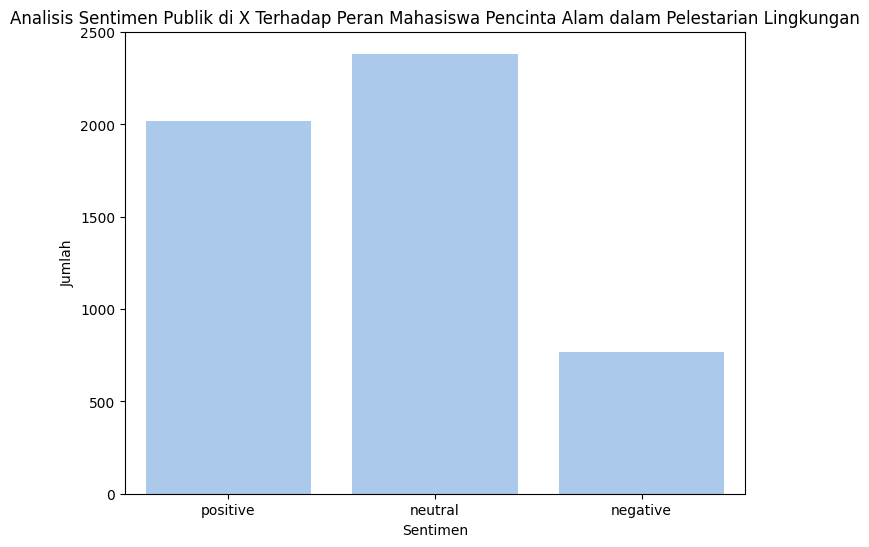

In [37]:
# Visualisasi
sns.set_palette("pastel")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimen', data=df)
plt.title('Analisis Sentimen Publik di X Terhadap Peran Mahasiswa Pencinta Alam dalam Pelestarian Lingkungan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [38]:
data_negatif = df[df['sentimen'] == 'negative']
data_positif = df[df['sentimen'] == 'positive']
data_netral = df[df['sentimen'] == 'neutral']

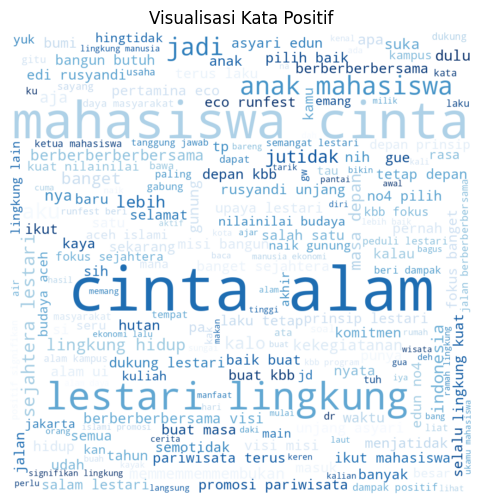

In [43]:
all_text_s1 = ' '.join(word for word in data_positif["full_text"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Positif")
plt.margins(x=0, y=0)
plt.show()

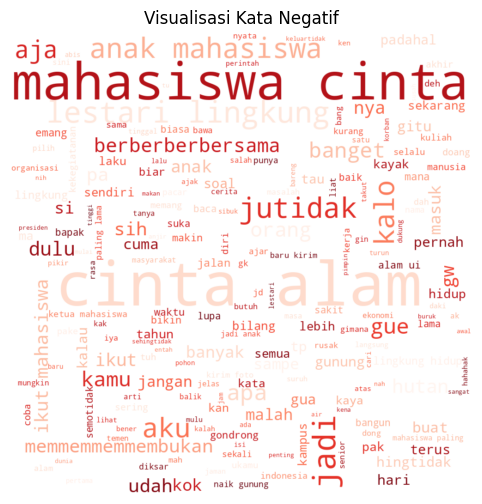

In [44]:
all_text_s0 = ' '.join(word for word in data_negatif["full_text"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Negatif")
plt.margins(x=0, y=0)
plt.show()

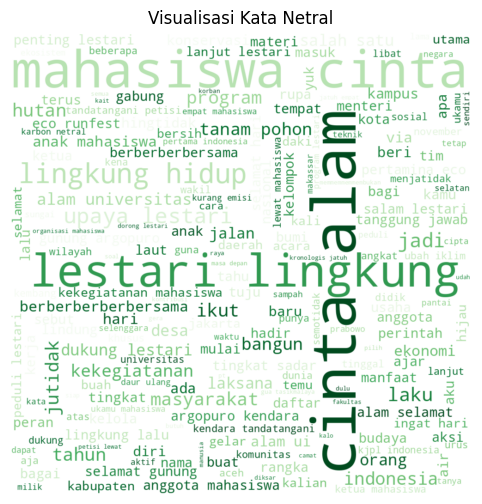

In [45]:
all_text_s2 = ' '.join(word for word in data_netral["full_text"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s2)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Netral")
plt.margins(x=0, y=0)
plt.show()

In [46]:
# Spliting Data
x=df.full_text
y=df.sentimen

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

In [51]:
print('\nBanyak data x_train :',len(x_train))
print('Banyak data x_test  :',len(x_test))
print('Banyak data y_train :',len(y_train))
print('Banyak data y_test  :',len(y_test))


Banyak data x_train : 4136
Banyak data x_test  : 1034
Banyak data y_train : 4136
Banyak data y_test  : 1034


In [53]:
# Training Data (Naive Bayes)
cvec=CountVectorizer()
tvec=TfidfVectorizer()
hvec=HashingVectorizer()

In [54]:
from sklearn.naive_bayes import MultinomialNB

clf1 = MultinomialNB()

In [55]:
model1 = Pipeline([('vectorizer',tvec)
                 ,('classifier',clf1)])

In [56]:
model1.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', MultinomialNB())])

In [57]:
hasil1=model1.predict(x_test)

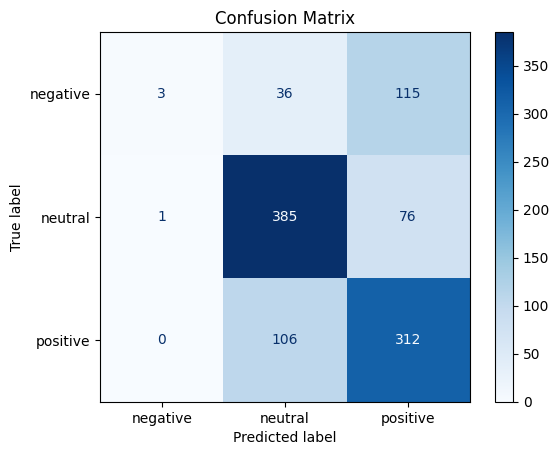

In [58]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test,hasil1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [59]:
matrix = classification_report(y_test,hasil1)
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

    negative       0.75      0.02      0.04       154
     neutral       0.73      0.83      0.78       462
    positive       0.62      0.75      0.68       418

    accuracy                           0.68      1034
   macro avg       0.70      0.53      0.50      1034
weighted avg       0.69      0.68      0.63      1034



In [62]:
print("\n--- INFORMASI INTERNAL MODEL NAIVE BAYES ---")



--- INFORMASI INTERNAL MODEL NAIVE BAYES ---


In [63]:
# 1. Akses TfidfVectorizer yang sudah dilatih
trained_vectorizer = model1.named_steps['vectorizer']

In [64]:
# 2. Akses MultinomialNB yang sudah dilatih
trained_classifier = model1.named_steps['classifier']

In [65]:
# 3. Dapatkan Vocabulary (Kosakata)
vocabulary = trained_vectorizer.vocabulary_
print("\nUkuran Vocabulary:", len(vocabulary))


Ukuran Vocabulary: 10478


In [66]:
# 4. Dapatkan Matriks TF-IDF dari x_train
X_train_tfidf = trained_vectorizer.transform(x_train)
print(f"\nShape Matriks TF-IDF (x_train): {X_train_tfidf.shape}")


Shape Matriks TF-IDF (x_train): (4136, 10478)


In [67]:
# 5. Dapatkan Nama Kelas
class_labels = trained_classifier.classes_
print("\nNama Kelas (Sentimen):", class_labels)


Nama Kelas (Sentimen): ['negative' 'neutral' 'positive']


In [68]:
# 6. Dapatkan Log Probabilitas Prior Kelas
log_prior_classes = trained_classifier.class_log_prior_
print("\nLog Probabilitas Prior Kelas:")
for i, label in enumerate(class_labels):
    print(f"  Log P({label}): {log_prior_classes[i]:.4f}")


Log Probabilitas Prior Kelas:
  Log P(negative): -1.9091
  Log P(neutral): -0.7669
  Log P(positive): -0.9485


In [69]:
# 7. Dapatkan Log Probabilitas Likelihood Fitur (Kata) per Kelas
log_likelihood_features = trained_classifier.feature_log_prob_
print(f"\nShape Log Probabilitas Likelihood Fitur: {log_likelihood_features.shape}")
# Contoh: Menampilkan 10 kata teratas dengan probabilitas tertinggi untuk setiap kelas
print("\n10 Kata Teratas dengan Probabilitas Tertinggi per Kelas:")
feature_names = trained_vectorizer.get_feature_names_out()
for i, class_label in enumerate(class_labels):
    # Dapatkan indeks fitur yang diurutkan berdasarkan probabilitas tertinggi untuk kelas ini
    top_10_indices = log_likelihood_features[i, :].argsort()[-10:][::-1]
    top_10_words = [feature_names[idx] for idx in top_10_indices]
    top_10_probs = [f"{log_likelihood_features[i, idx]:.4f}" for idx in top_10_indices]
    print(f"  Kelas '{class_label}':")
    for j in range(10):
        print(f"    - {top_10_words[j]} (Log Prob: {top_10_probs[j]})")


Shape Log Probabilitas Likelihood Fitur: (3, 10478)

10 Kata Teratas dengan Probabilitas Tertinggi per Kelas:
  Kelas 'negative':
    - mahasiswa (Log Prob: -5.8076)
    - cinta (Log Prob: -5.8600)
    - alam (Log Prob: -5.8856)
    - anak (Log Prob: -6.5692)
    - jadi (Log Prob: -6.7083)
    - kalo (Log Prob: -6.8531)
    - jutidak (Log Prob: -6.9082)
    - aku (Log Prob: -7.0446)
    - aja (Log Prob: -7.0925)
    - ikut (Log Prob: -7.1089)
  Kelas 'neutral':
    - lingkung (Log Prob: -5.2139)
    - lestari (Log Prob: -5.2953)
    - alam (Log Prob: -5.4665)
    - mahasiswa (Log Prob: -5.4925)
    - cinta (Log Prob: -5.5194)
    - hidup (Log Prob: -6.2356)
    - upaya (Log Prob: -6.4054)
    - selamat (Log Prob: -6.4920)
    - masyarakat (Log Prob: -6.5640)
    - indonesia (Log Prob: -6.5866)
  Kelas 'positive':
    - cinta (Log Prob: -4.9567)
    - alam (Log Prob: -4.9587)
    - mahasiswa (Log Prob: -4.9721)
    - lingkung (Log Prob: -5.5200)
    - lestari (Log Prob: -5.5242)
    - 

In [75]:
# Testing
def classify_text(input_text):
    prediction = model1.predict([input_text])
    return prediction[0]
input_text = input("\nMasukkan teks yang ingin diklasifikasikan: ")
results = classify_text(input_text)
print("Input kata :", input_text)
print(f"\nHasil Klasifikasi (MultinomialNB): {results}")


Masukkan teks yang ingin diklasifikasikan: pelestarian lingkungan
Input kata : pelestarian lingkungan

Hasil Klasifikasi (MultinomialNB): neutral
